# Yelp Review Scaper

In this notebook, we are goint to start by creating a scrapper for one specific yelp restaurant website. After sucessfully doing so, we will modularize the process into a function and scrape reviews for all the restaurants in the area and store it in a DataFrame. We are going to access the table we worked on in the previous part and then extract the reviews for them and then assign them a sentiment analysis score using 2 different methods. Finally, we will do some more data cleaning so that the data is available for ad-hoc analysis in Business Tools like Tableau.

In [77]:
#importing necessary libraries
import requests
import pandas as pd 
import numpy as np 
import nltk
import seaborn as sns 
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashishraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ashishraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [78]:
#requesting a single page
r = requests.get('https://www.yelp.com/biz/the-river-seafood-and-oyster-bar-miami?page_src=related_bizes')
print(r.status_code) #Successful implementation will result print the value of 200

200


In [3]:
#converting the text into a BeautifulSoup object
soup = BeautifulSoup(r.text,'html.parser')

#The reviews are stored in a div class. We will use FindAll function to get the reviews.
#<div class="lemon--div__373c0__1mboc u-space-b2 border-color--default__373c0__2oFDT">
results = soup.findAll(class_ = "lemon--p__373c0__3Qnnj text__373c0__2pB8f comment__373c0__3EKjH text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_" )

In [4]:
# Loop through review-content divs and extract paragraph text
reviews =[]
for result in results:
    reviews.append(result.find('span').text)
for review in reviews: 
    print(review,'\n')

Place has a really good ambiance for happy hour, and cocktails are amazing The food and service is really good too, we ordered the octopus as an appetizer and it was amazing then we had the mussels the broth was way too salty but I've been there in the Pat and this was the first time something like that happened. We also had a lobster bun and just as a heads up is no bun is more like a burger is really big. And if you are obsessed about dessert you can't miss their panna cotta one of the best ones I've had in a long time it's so creamy and fresh with a berries could on top and some Mynt, omg to die for. Make sure to reserve beforehand bc it tends to get crowded. 

If you like seafood, especially oysters, then this is the place to be at in Brickell!  They have great happy hour specials and a nice outdoor patio to do drinks with your friends, and people watch--quite a number of chairs. The staff here are friendly and quick at getting what you need. For parking, I suggest to do the reason

From above we can see that we have sucessfully extracted all the reviews from the first page of the restaurant page on Yelp. 

# Analysing Review

We are going to begin analysing the reviews by first converting it into a DataFrame. After this we will add some quantitative analysis metrics to have a better understanding about how the review will perform under textblob sentiment  analysis. We do this by creating columns word count, character count, average word count, stop word count and rate columns. (Stopwords are words that when removed from a sentence doesn't change the meaning of the sentence. For Example, a statment of "My dog is the best and the prettiest" will simply read "My dog best prettiest" after we remove the stop words)

In [5]:
#convert the reviews array into a dataframe
df = pd.DataFrame(np.array(reviews),columns = ['review'])
df.head()

,review
0,Place has a really good ambiance for happy hou...
1,"If you like seafood, especially oysters, then ..."
2,This restaurant is a favorite among Miamians. ...
3,I went for lunch with a friend and sat at the ...
4,Locals know #onatuesday longstanding $20 #lobs...


In [6]:
# Calculate word count
df['word_count'] = df['review'].apply(lambda x: len(str(x).split(" ")))
# Calculate character count
df['char_count'] = df['review'].str.len()

In [7]:
# Calculate avg_word
def avg_word(review):
  words = review.split()
  return (sum(len(word) for word in words) / len(words))

# Calculate average words
df['avg_word'] = df['review'].apply(lambda x: avg_word(x))

In [8]:
#calculating stopwords count and rate 
stop_words = stopwords.words('english')
df['stopword_count'] = df['review'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
df['stopword_rate'] = df['stopword_count']/df['word_count']

In [9]:
df.head()

,review,word_count,char_count,avg_word,stopword_count,stopword_rate
0,Place has a really good ambiance for happy hou...,136,670,3.933824,67,0.492647
1,"If you like seafood, especially oysters, then ...",80,445,4.562500,34,0.425000
2,This restaurant is a favorite among Miamians. ...,185,1004,4.432432,70,0.378378
3,I went for lunch with a friend and sat at the ...,217,1176,4.423963,76,0.350230
4,Locals know #onatuesday longstanding $20 #lobs...,50,329,5.600000,19,0.380000


# Data Cleaning 

In the previous section, we cleaned the review data, converted it to a DataFrame and added some metrics. While the review is readable for us, we have to make some changes before we can conduct an NLP sentiment analysis on it. 

We have to address the following characteristics of the reviews:- 
* Lower Case - Converting all of the words to lower case. This will prevent the algorithm from treating the capitalized form as different word.
* Punctuation - Removing all punctuations to make it easier for the library to analyse.
* Stemming/Lemmatization - Stripping words down to their root form to reduce processing time and variable storage.

Removing these features of the review will allow us the sentiment analyser to accurately assess the review as the overall sentiment of the review will not be affected by words that we speak for smoother communication and liguistic aesthetics.

In [10]:
# Lower case all words
df['review_lower'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove Punctuation
df['review_nopunc'] = df['review_lower'].str.replace('[^\w\s]', '')

# Import stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Remove Stopwords
df['review_nopunc_nostop'] = df['review_nopunc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

# Return frequency of values
freq= pd.Series(" ".join(df['review_nopunc_nostop']).split()).value_counts()[:30]

In [11]:
# Lemmatize final review format
df['cleaned_review'] = df['review_nopunc_nostop']\
.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [12]:
df.head()

,review,word_count,char_count,avg_word,stopword_count,stopword_rate,review_lower,review_nopunc,review_nopunc_nostop,cleaned_review
0,Place has a really good ambiance for happy hou...,136,670,3.933824,67,0.492647,place has a really good ambiance for happy hou...,place has a really good ambiance for happy hou...,place really good ambiance happy hour cocktail...,place really good ambiance happy hour cocktail...
1,"If you like seafood, especially oysters, then ...",80,445,4.562500,34,0.425000,"if you like seafood, especially oysters, then ...",if you like seafood especially oysters then th...,like seafood especially oysters place brickell...,like seafood especially oyster place brickell ...
2,This restaurant is a favorite among Miamians. ...,185,1004,4.432432,70,0.378378,this restaurant is a favorite among miamians. ...,this restaurant is a favorite among miamians w...,restaurant favorite among miamians longer live...,restaurant favorite among miamians longer live...
3,I went for lunch with a friend and sat at the ...,217,1176,4.423963,76,0.350230,i went for lunch with a friend and sat at the ...,i went for lunch with a friend and sat at the ...,went lunch friend sat bar immediately ordered ...,went lunch friend sat bar immediately ordered ...
4,Locals know #onatuesday longstanding $20 #lobs...,50,329,5.600000,19,0.380000,locals know #onatuesday longstanding $20 #lobs...,locals know onatuesday longstanding 20 lobster...,locals know onatuesday longstanding 20 lobster...,local know onatuesday longstanding 20 lobstern...


# Sentiment Analysis

Now that we have converted the review data that is more useful with the help of the NLTK library. We are ready to conduct a sentiment analysis on this review data. A sentiment analysis is an analytic tool that comes with the textblob library which allows to understand the contextual meaning of a text by assigning a score to it. 

The textblob.sentiments module contains two sentiment analysis implementations, PatternAnalyzer (based on the pattern library) and NaiveBayesAnalyzer (an NLTK classifier trained on a movie reviews corpus).

There are two scores that will be used to analyse the sentiment behind a text - 

* sentiment - Quanitifies the objectivity of a statement on a scale of 0-1, where 0 is purely objective and 1 is purely subjective

* polarity - Quanitifies the sentiment of the statement on a scale of -1 to 1, where -1 is extremely negative and +1 is extremely positive.

In [13]:
# Calculate polarity
from textblob import TextBlob
df['polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment[0])

In [14]:
# Calculate subjectivity
df['subjectivity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment[1])

In [15]:
df.head()

,review,word_count,char_count,avg_word,stopword_count,stopword_rate,review_lower,review_nopunc,review_nopunc_nostop,cleaned_review,polarity,subjectivity
0,Place has a really good ambiance for happy hou...,136,670,3.933824,67,0.492647,place has a really good ambiance for happy hou...,place has a really good ambiance for happy hou...,place really good ambiance happy hour cocktail...,place really good ambiance happy hour cocktail...,0.415385,0.617094
1,"If you like seafood, especially oysters, then ...",80,445,4.562500,34,0.425000,"if you like seafood, especially oysters, then ...",if you like seafood especially oysters then th...,like seafood especially oysters place brickell...,like seafood especially oyster place brickell ...,0.336548,0.632143
2,This restaurant is a favorite among Miamians. ...,185,1004,4.432432,70,0.378378,this restaurant is a favorite among miamians. ...,this restaurant is a favorite among miamians w...,restaurant favorite among miamians longer live...,restaurant favorite among miamians longer live...,0.348121,0.726175
3,I went for lunch with a friend and sat at the ...,217,1176,4.423963,76,0.350230,i went for lunch with a friend and sat at the ...,i went for lunch with a friend and sat at the ...,went lunch friend sat bar immediately ordered ...,went lunch friend sat bar immediately ordered ...,0.187419,0.652366
4,Locals know #onatuesday longstanding $20 #lobs...,50,329,5.600000,19,0.380000,locals know #onatuesday longstanding $20 #lobs...,locals know onatuesday longstanding 20 lobster...,locals know onatuesday longstanding 20 lobster...,local know onatuesday longstanding 20 lobstern...,0.187500,0.187500


Now that we have successfully found the subjectivity and polarity scores for all the reviews for one restaraunt. We are going to create a new DataFrame and calculate the mean of the polarity and subjectivity score of all of the reviews for all restaurants and then assignt that score to that restaurant . We will do this for the rest of the restaurants. 

The code below is taken from Part 1 of the assignment.

In [16]:
#Define the API key, define the endpoint, define the header 
API_KEY = 'GxuSZq20NHph7uqSkyaoYu4SIqvl1YJsCfqeKJngbcudfhVyMbEySnD9aDvUtBqwulkcLAdmsB4qrI0BWZ00QPq9ZKdLBQ1KHgyy1Dlj8hfTA_Kb8yVMmgJYLuTiXXYx'
ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
HEADERS = {'Authorization' : 'bearer %s' % API_KEY } 

#Define the parameters of the query
PARAMETER = {'term':'restaurants',
              'limit' : 50, 
              'radius' : 2000,
             #'offset':50,
              'location' : '50 SW 12th St, Miami, FL 33130'}

#make a request to the yelp API 
response = requests.get(url = ENDPOINT, params = PARAMETER, headers = HEADERS)

#convert the json string to a dictionary 
business_data = response.json()

df1 = pd.DataFrame.from_dict(business_data['businesses'],orient = 'columns')
df1 = df1.rename(columns = {'display_phone':'phone','id':'restaurant_id','rating':'avg_rating'})

#To get the reviews of the business 
business_id = df1[['name','url','restaurant_id',]]

business_id.head()

,name,url,restaurant_id
0,Crazy About You,https://www.yelp.com/biz/crazy-about-you-miami...,ix8ifP1jQM9ektdVAs19sQ
1,CVI.CHE 105,https://www.yelp.com/biz/cvi-che-105-miami?adj...,1h8-r9cLeXxW99HhlRUnlA
2,Batch Gastropub - Miami,https://www.yelp.com/biz/batch-gastropub-miami...,d1-i5ZPBfHagwQW5uvBLSg
3,BOSS COW,https://www.yelp.com/biz/boss-cow-miami-2?adju...,Bt19UToGQNKJHKuWzGVPbA
4,Gyu-Kaku Japanese BBQ,https://www.yelp.com/biz/gyu-kaku-japanese-bbq...,wUgicT0LJbrHnav4d8SwSA


Following from what we did above we are going to modularise the process using a for loop and then store the scores in a Sentiment Analysis DataFrame. We are going to modify the code that we used in Part 1, store the urls, subjectivity and polarity score. 

In [17]:
url = []
subjectivity = []
polarity = []

for i in business_id['url']:
    r = requests.get(i)
    soup = BeautifulSoup(r.text,'html.parser')
    results = soup.findAll(class_ = "lemon--p__373c0__3Qnnj text__373c0__2pB8f comment__373c0__3EKjH text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_" )

    reviews = []

    for result in results:
        reviews.append(result.find('span').text)

    #convert the reviews array into a dataframe
    df = pd.DataFrame(np.array(reviews),columns = ['review'])
    stop_words = stopwords.words('english')
    
    # Lower case all words
    df['review_lower'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Remove Punctuation
    df['review_nopunc'] = df['review_lower'].str.replace('[^\w\s]', '')
    
    # Remove Stopwords
    df['review_nopunc_nostop'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

    # Return frequency of values
    freq= pd.Series(" ".join(df['review_nopunc_nostop']).split()).value_counts()[:30]

    # Lemmatize final review format
    df['cleaned_review'] = df['review_nopunc_nostop']\
    .apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    # Calculate polarity
    from textblob import TextBlob
    from statistics import mean
    df['polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment[0])

    # Calculate subjectivity
    df['subjectivity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment[1])

    #calculate average polarity and average subjectivity 
    avg_subjectivity = df['subjectivity'].mean()
    avg_polarity = df['polarity'].mean()

    polarity.append(round(avg_polarity,2))
    subjectivity.append(round(avg_subjectivity,2))
    url.append(i)
    print("{} has a Subjectivity of {} and polarity of {}".format(i,avg_polarity,avg_subjectivity))

https://www.yelp.com/biz/crazy-about-you-miami-3?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.280129431404586 and polarity of 0.5931236233019125
https://www.yelp.com/biz/cvi-che-105-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.36744770765190865 and polarity of 0.5928593162908022
https://www.yelp.com/biz/batch-gastropub-miami-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.2683164078680996 and polarity of 0.5449684726649014
https://www.yelp.com/biz/boss-cow-miami-2?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.32807355122449317 and polarity of

https://www.yelp.com/biz/naoe-miami-3?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.26776687095348434 and polarity of 0.5374723159887402
https://www.yelp.com/biz/coyo-taco-miami-2?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.23611632237588118 and polarity of 0.581071537524295
https://www.yelp.com/biz/obra-kitchen-table-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.2698306406127522 and polarity of 0.5438409760005708
https://www.yelp.com/biz/the-river-seafood-and-oyster-bar-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a Subjectivity of 0.3179162079971363 and pol

In [18]:
#zipping the subjectivitity and polarity lists into a DataFrame and merging the subsequent DataFrames.
subjectivity = pd.DataFrame(list(zip(url,subjectivity)),columns =['url', 'subjectivity']) 
polarity = pd.DataFrame(list(zip(url,polarity)),columns =['url', 'polarity'])
sentiment_analysis = pd.merge(subjectivity,polarity, on = 'url')

We have two scores available to us for analysing the sentiment of the review  - subjectivity and polarity. 

In [19]:
sentiment_analysis.head()

,url,subjectivity,polarity
0,https://www.yelp.com/biz/crazy-about-you-miami...,0.59,0.28
1,https://www.yelp.com/biz/cvi-che-105-miami?adj...,0.59,0.37
2,https://www.yelp.com/biz/batch-gastropub-miami...,0.54,0.27
3,https://www.yelp.com/biz/boss-cow-miami-2?adju...,0.63,0.33
4,https://www.yelp.com/biz/gyu-kaku-japanese-bbq...,0.59,0.39


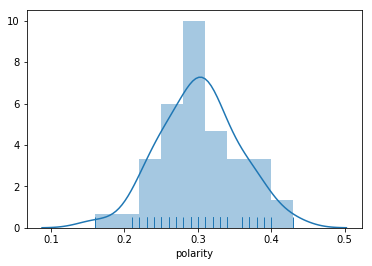

In [20]:
sns.distplot(sentiment_analysis['polarity'], rug = True )

From the above graph it seems that most of the reviews have a sentiment score between 0.15 and 0.25. This doesnt corroborate the average rating distribution. The sentiment scores are closer to 0, which implies a customer indifference, (an average experience).

# Vader Analysis 

Now that we have conducted a sentiment analysis on the dataset, we are going to use a more sophisticated form of sentiment analysis. The 'Vader' library, built on the NLTK library, was specfically trained to analyse different types of reviews such as movie reviews, product reviews, editorials and tweets etc. The reason why I first went over sentiment analysis in NLTK library was to show how intensive the process can be just for analysing 50 reviews, not to forget the processsing time and the storage capacity that would be needed to scale this process. 

Vader overcomes this specifically by utilizing the shortcomings of the NLTK process by implementing it in its analyzer instance. Vader specifically analyses sentiments based on parameters such as punctuation, capitalization, modifiers, conjunctions and preceding text inference.

The following extract has been taken from Vader's Documentation (https://github.com/cjhutto/vaderSentiment#about-the-scoring) and delineates its scoring : - 

* The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

* It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

    * positive sentiment: compound score >= 0.05
    * neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    * negative sentiment: compound score <= -0.05

* The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [21]:
import requests 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline


#Define the API key, define the endpoint, define the header 
API_KEY = 'GxuSZq20NHph7uqSkyaoYu4SIqvl1YJsCfqeKJngbcudfhVyMbEySnD9aDvUtBqwulkcLAdmsB4qrI0BWZ00QPq9ZKdLBQ1KHgyy1Dlj8hfTA_Kb8yVMmgJYLuTiXXYx'
ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
HEADERS = {'Authorization' : 'bearer %s' % API_KEY } 

#Define the parameters of the query
PARAMETER = {'term':'restaurants',
              'limit' : 50, 
              'radius' : 2000,
             #'offset':50,
              'location' : '50 SW 12th St, Miami, FL 33130'}

#make a request to the yelp API 
response = requests.get(url = ENDPOINT, params = PARAMETER, headers = HEADERS)

#convert the json string to a dictionary 
business_data = response.json()

df1 = pd.DataFrame.from_dict(business_data['businesses'],orient = 'columns')
df1 = df1.rename(columns = {'display_phone':'phone','id':'restaurant_id','rating':'avg_rating'})

#To get the reviews of the business 
business_id = df1[['name','url','restaurant_id',]]

business_id.head()

,name,url,restaurant_id
0,Crazy About You,https://www.yelp.com/biz/crazy-about-you-miami...,ix8ifP1jQM9ektdVAs19sQ
1,CVI.CHE 105,https://www.yelp.com/biz/cvi-che-105-miami?adj...,1h8-r9cLeXxW99HhlRUnlA
2,Batch Gastropub - Miami,https://www.yelp.com/biz/batch-gastropub-miami...,d1-i5ZPBfHagwQW5uvBLSg
3,BOSS COW,https://www.yelp.com/biz/boss-cow-miami-2?adju...,Bt19UToGQNKJHKuWzGVPbA
4,Gyu-Kaku Japanese BBQ,https://www.yelp.com/biz/gyu-kaku-japanese-bbq...,wUgicT0LJbrHnav4d8SwSA


In [22]:
#Verifying that the links taken from the Yelp API are functional.
from urllib.request import urlopen
from bs4 import BeautifulSoup

for i in business_id['url']:
    try:
        html = urlopen(i)
    except HTTPError as e:
        print(e)
        #return null, break, or do some other "Plan B"
    else:
        bsObj = BeautifulSoup(html.read());
        print(bsObj.title)
    

<title>Crazy About You - 2019 All You Need to Know BEFORE You Go (with Photos) Mediterranean - Yelp</title>
<title>CVI.CHE 105 - 2019 All You Need to Know BEFORE You Go (with Photos) Peruvian - Yelp</title>
<title>Batch Gastropub - Miami - 2019 All You Need to Know BEFORE You Go (with Photos) Gastropubs - Yelp</title>
<title>BOSS COW - 2019 All You Need to Know BEFORE You Go (with Photos) Brasseries - Yelp</title>
<title>Gyu-Kaku Japanese BBQ - 2019 All You Need to Know BEFORE You Go (with Photos) Japanese - Yelp</title>
<title>Dolores But You Can Call Me Lolita - 2019 All You Need to Know BEFORE You Go (with Photos) American (New) - Yelp</title>
<title>North Italia - 2019 All You Need to Know BEFORE You Go (with Photos) Italian - Yelp</title>
<title>The Wharf Miami - 2019 All You Need to Know BEFORE You Go (with Photos) Music Venues - Yelp</title>
<title>DC PIE CO. Brickell - 61 Photos &amp; 52 Reviews - Bars - 1010 Brickell Ave, Brickell, Miami, FL - Restaurant Reviews - Phone Number

In [23]:
vader_score = []
url = []

for i in business_id['url']:
    r = requests.get(i)
    soup = BeautifulSoup(r.text,'html.parser')
    results = soup.findAll(class_ = "lemon--p__373c0__3Qnnj text__373c0__2pB8f comment__373c0__3EKjH text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_" )

    reviews = []

    for result in results:
        reviews.append(result.find('span').text)

    #convert the reviews array into a dataframe
    df = pd.DataFrame(np.array(reviews),columns = ['review'])
    stop_words = stopwords.words('english')

    # Return frequency of values
    freq= pd.Series(" ".join(df['review']).split()).value_counts()[:30]
    
    #calculating the sentiment for restaurant for multiple reviews
    analyser = SentimentIntensityAnalyzer()
    rating = []
    from statistics import mean

    for j in df['review']:
        score = analyser.polarity_scores(j)
        rating.append((score['compound']))
    
    vader_score.append(round(mean(rating),2))
    url.append(i)
    print("{} has a VADER Score of {}".format(i,mean(rating)))

https://www.yelp.com/biz/crazy-about-you-miami-3?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.844865
https://www.yelp.com/biz/cvi-che-105-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.92308
https://www.yelp.com/biz/batch-gastropub-miami-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.872005
https://www.yelp.com/biz/boss-cow-miami-2?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.916895
https://www.yelp.com/biz/gyu-kaku-japanese-bbq-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtU

https://www.yelp.com/biz/la-mar-by-gaston-acurio-miami-5?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.85094
https://www.yelp.com/biz/yuzi-yakitori-miami-6?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.867245
https://www.yelp.com/biz/barsecco-miami-3?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.9157
https://www.yelp.com/biz/momi-ramen-miami?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41xBlbmGw has a VADER Score of 0.579495
https://www.yelp.com/biz/baby-jane-miami-2?adjust_creative=TLtUxGloO6F2j41xBlbmGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=TLtUxGloO6F2j41

In [24]:
#converting the vader_score and url lists into a DataFrame
vaderdf = pd.DataFrame(list(zip(url,vader_score)),columns =['url', 'vader_score'])

In [36]:
#merging vaderdf and df1 on 'url'
review_df = pd.merge(vaderdf,df1, on = 'url')
review_df['sentiment_score'] = sentiment_analysis['polarity']
review_df

,url,vader_score,alias,categories,coordinates,phone,distance,restaurant_id,image_url,is_closed,location,name,phone,price,avg_rating,review_count,transactions,sentiment_score
0,https://www.yelp.com/biz/crazy-about-you-miami...,0.84,crazy-about-you-miami-3,"[{'alias': 'mediterranean', 'title': 'Mediterr...","{'latitude': 25.7620078715623, 'longitude': -8...",(305) 377-4442,542.307321,ix8ifP1jQM9ektdVAs19sQ,https://s3-media3.fl.yelpcdn.com/bphoto/YYPRTE...,False,"{'address1': '1155 Brickell Bay Dr', 'address2...",Crazy About You,+13053774442,$$,4.0,1522,"[delivery, restaurant_reservation, pickup]",0.28
1,https://www.yelp.com/biz/cvi-che-105-miami?adj...,0.92,cvi-che-105-miami,"[{'alias': 'peruvian', 'title': 'Peruvian'}, {...","{'latitude': 25.775383, 'longitude': -80.1884004}",(305) 577-3454,1586.171706,1h8-r9cLeXxW99HhlRUnlA,https://s3-media3.fl.yelpcdn.com/bphoto/ygUI2y...,False,"{'address1': '105 NE 3rd Ave', 'address2': '',...",CVI.CHE 105,+13055773454,$$,4.5,3582,[delivery],0.37
2,https://www.yelp.com/biz/batch-gastropub-miami...,0.87,batch-gastropub-miami-miami,"[{'alias': 'gastropubs', 'title': 'Gastropubs'...","{'latitude': 25.7624962180853, 'longitude': -8...",(305) 808-5555,52.039867,d1-i5ZPBfHagwQW5uvBLSg,https://s3-media4.fl.yelpcdn.com/bphoto/6UPqM2...,False,"{'address1': '30 SW 12th St', 'address2': None...",Batch Gastropub - Miami,+13058085555,$$,4.0,1056,"[delivery, pickup]",0.27
3,https://www.yelp.com/biz/boss-cow-miami-2?adju...,0.92,boss-cow-miami-2,"[{'alias': 'brasseries', 'title': 'Brasseries'...","{'latitude': 25.76377, 'longitude': -80.19345}",(786) 218-9698,200.794196,Bt19UToGQNKJHKuWzGVPbA,https://s3-media4.fl.yelpcdn.com/bphoto/5Mp1uy...,False,"{'address1': '1036 S Miami Ave', 'address2': N...",BOSS COW,+17862189698,NaN,4.5,27,[],0.33
4,https://www.yelp.com/biz/gyu-kaku-japanese-bbq...,0.94,gyu-kaku-japanese-bbq-miami,"[{'alias': 'japanese', 'title': 'Japanese'}, {...","{'latitude': 25.7614869910215, 'longitude': -8...",(305) 400-8915,75.510410,wUgicT0LJbrHnav4d8SwSA,https://s3-media4.fl.yelpcdn.com/bphoto/tFMCV8...,False,"{'address1': '34 SW 13th St', 'address2': 'Uni...",Gyu-Kaku Japanese BBQ,+13054008915,$$,4.0,1267,[delivery],0.39
5,https://www.yelp.com/biz/dolores-but-you-can-c...,0.91,dolores-but-you-can-call-me-lolita-miami,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 25.76427, 'longitude': -80.19354}",(305) 403-3103,250.230895,aIQK1sw9Prr-KdUu717vRw,https://s3-media3.fl.yelpcdn.com/bphoto/ypMXGU...,False,"{'address1': '1000 S Miami Ave', 'address2': '...",Dolores But You Can Call Me Lolita,+13054033103,$$,4.0,1040,"[delivery, restaurant_reservation, pickup]",0.33
6,https://www.yelp.com/biz/north-italia-miami-3?...,0.93,north-italia-miami-3,"[{'alias': 'italian', 'title': 'Italian'}]","{'latitude': 25.76523, 'longitude': -80.1935}",(786) 475-9100,349.656053,BlZqSfhGYf4gdQlMkKXU4A,https://s3-media2.fl.yelpcdn.com/bphoto/l9x6e9...,False,"{'address1': '900 S Miami Ave', 'address2': 'S...",North Italia,+17864759100,$$,4.5,292,[],0.32
7,https://www.yelp.com/biz/the-wharf-miami-miami...,0.92,the-wharf-miami-miami,"[{'alias': 'musicvenues', 'title': 'Music Venu...","{'latitude': 25.77264, 'longitude': -80.1998799}",(305) 906-4000,1290.417667,lmmFNizrRMyZal3dUQP34g,https://s3-media3.fl.yelpcdn.com/bphoto/0v4G05...,False,"{'address1': '114 SW North River Dr', 'address...",The Wharf Miami,+13059064000,$$,4.0,492,"[delivery, restaurant_reservation]",0.38
8,https://www.yelp.com/biz/dc-pie-co-brickell-mi...,0.90,dc-pie-co-brickell-miami-3,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...","{'latitude': 25.764014, 'longitude': -80.192263}",(786) 453-6888,294.242622,anAxMJXChsZ-f546JeZjfQ,https://s3-media1.fl.yelpcdn.com/bphoto/9eyFUx...,False,"{'address1': '1010 Brickell Ave', 'address2': ...",DC PIE CO. Brickell,+17864536888,NaN,4.0,52,[],0.36
9,https://www.yelp.com/biz/vero-miami-3?adjust_c...,0.97,vero-miami-3,"[{'alias': 'italian', 'title': 'Italian'}, {'a...","{'latitude': 25.773247

In [37]:
#looking at the statistical distribution of vader scores 
review_df['vader_score'].describe()

count    50.000000
mean      0.840200
std       0.112077
min       0.500000
25%       0.820000
50%       0.865000
75%       0.917500
max       0.970000
Name: vader_score, dtype: float64

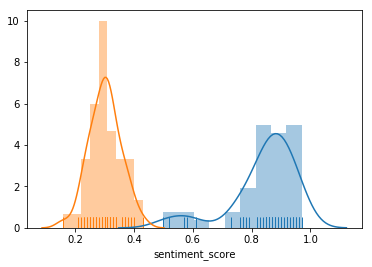

In [38]:
#viewing the distri
sns.distplot(review_df['vader_score'], rug = True, label = 'Vader Score')
sns.distplot(review_df['sentiment_score'], rug = True, label = 'Sentiment Score')

From the above graphs we can see that the vader score has a greater variance than sentiment score. It is also interesting to observe that while the sentiment score ranges from 0.6 to 9.5, sentiment score is concentrated around 0.2 to 0.4. 

Finally, we have our data that is ready for analysis. However, looking at the 'price', 'coordinates' and 'categories' columns, we still have some cleaning to do.

In [39]:
#unpacking the dict in Categories column, in a new column called Cuisine.
keywords  = []
for i in range(0,len(review_df['categories'])):
    items = []
    for j in range(0,len(review_df['categories'][i])):
        items.append(review_df['categories'][i][j]['title'])
    keywords.append(items)
review_df['cuisine'] = keywords
review_df.head()
review_df = review_df.drop(columns = ['categories'])

In [40]:
#mapping the '$' format on a scale of 1-4
review_df['price'] = review_df['price'].map({'$':1,'$$':2,'$$$':3,'$$$$':4})

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
# unpacking the coordinates 
keywords  = []
for i in range(0,len(review_df['coordinates'])):
    items = []
    for j in range(0,len(review_df['coordinates'][i])-1):
        items.append(review_df['coordinates'][i]['latitude'])
        items.append(review_df['coordinates'][i]['longitude'])
    keywords.append(items)

review_df['coordinates'] = keywords

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [42]:
#Splitting the coordinates dataframe into latitude and longitude 
latitude = []
longitude = []
for i in range(0,len(review_df['coordinates'])):
    latitude.append(review_df['coordinates'][i][0])
    longitude.append(review_df['coordinates'][i][1])
review_df['latitude'] = latitude
review_df['longitude'] = longitude 

In [44]:
review_df.head()

,url,vader_score,alias,coordinates,phone,distance,restaurant_id,image_url,is_closed,location,name,phone,price,avg_rating,review_count,transactions,sentiment_score,cuisine,latitude,longitude
0,https://www.yelp.com/biz/crazy-about-you-miami...,0.84,crazy-about-you-miami-3,"[25.7620078715623, -80.1889463275432]",(305) 377-4442,542.307321,ix8ifP1jQM9ektdVAs19sQ,https://s3-media3.fl.yelpcdn.com/bphoto/YYPRTE...,False,"{'address1': '1155 Brickell Bay Dr', 'address2...",Crazy About You,+13053774442,2.0,4.0,1522,"[delivery, restaurant_reservation, pickup]",0.28,"[Mediterranean, Italian, Spanish]",25.762008,-80.188946
1,https://www.yelp.com/biz/cvi-che-105-miami?adj...,0.92,cvi-che-105-miami,"[25.775383, -80.1884004]",(305) 577-3454,1586.171706,1h8-r9cLeXxW99HhlRUnlA,https://s3-media3.fl.yelpcdn.com/bphoto/ygUI2y...,False,"{'address1': '105 NE 3rd Ave', 'address2': '',...",CVI.CHE 105,+13055773454,2.0,4.5,3582,[delivery],0.37,"[Peruvian, Seafood]",25.775383,-80.188400
2,https://www.yelp.com/biz/batch-gastropub-miami...,0.87,batch-gastropub-miami-miami,"[25.7624962180853, -80.1939906924963]",(305) 808-5555,52.039867,d1-i5ZPBfHagwQW5uvBLSg,https://s3-media4.fl.yelpcdn.com/bphoto/6UPqM2...,False,"{'address1': '30 SW 12th St', 'address2': None...",Batch Gastropub - Miami,+13058085555,2.0,4.0,1056,"[delivery, pickup]",0.27,"[Gastropubs, American (New), Bars]",25.762496,-80.193991
3,https://www.yelp.com/biz/boss-cow-miami-2?adju...,0.92,boss-cow-miami-2,"[25.76377, -80.19345]",(786) 218-9698,200.794196,Bt19UToGQNKJHKuWzGVPbA,https://s3-media4.fl.yelpcdn.com/bphoto/5Mp1uy...,False,"{'address1': '1036 S Miami Ave', 'address2': N...",BOSS COW,+17862189698,NaN,4.5,27,[],0.33,"[Brasseries, Steakhouses, Wine Bars]",25.763770,-80.193450
4,https://www.yelp.com/biz/gyu-kaku-japanese-bbq...,0.94,gyu-kaku-japanese-bbq-miami,"[25.7614869910215, -80.1943418392868]",(305) 400-8915,75.510410,wUgicT0LJbrHnav4d8SwSA,https://s3-media4.fl.yelpcdn.com/bphoto/tFMCV8...,False,"{'address1': '34 SW 13th St', 'address2': 'Uni...",Gyu-Kaku Japanese BBQ,+13054008915,2.0,4.0,1267,[delivery],0.39,"[Japanese, Barbeque, Asian Fusion]",25.761487,-80.194342


In [51]:
cuisine =pd.DataFrame(columns=['Restaurant', 'Cuisine'])

In [52]:
cuisine

,Restaurant,Cuisine


In [45]:
review_df['cuisine']  = review_df['cuisine'].astype(str)
review_df['cuisine'] = review_df['cuisine'].str.strip("[]")
review_df['cuisine']

0                 'Mediterranean', 'Italian', 'Spanish'
1                                 'Peruvian', 'Seafood'
2                'Gastropubs', 'American (New)', 'Bars'
3              'Brasseries', 'Steakhouses', 'Wine Bars'
4                'Japanese', 'Barbeque', 'Asian Fusion'
5       'American (New)', 'Cocktail Bars', 'Tapas Bars'
6                                             'Italian'
7     'Music Venues', 'Pop-Up Restaurants', 'Cocktai...
8                      'Bars', 'Pizza', 'Chicken Wings'
9                                    'Italian', 'Pizza'
10                                   'Peruvian', 'Bars'
11    'Breakfast & Brunch', 'American (Traditional)'...
12                'Dim Sum', 'Cocktail Bars', 'Seafood'
13                     'Sushi Bars', 'Thai', 'Japanese'
14           'Asian Fusion', 'Lounges', 'Cocktail Bars'
15         'Steakhouses', 'Tapas Bars', 'Cocktail Bars'
16                  'Cuban', 'Cocktail Bars', 'Seafood'
17                             'Seafood', 'Steak

In [46]:
#converting the series from list to str
review_df['cuisine'] = review_df['cuisine'].str.strip("''")

In [49]:
review_df['cuisine']

0                   Mediterranean', 'Italian', 'Spanish
1                                   Peruvian', 'Seafood
2                  Gastropubs', 'American (New)', 'Bars
3                Brasseries', 'Steakhouses', 'Wine Bars
4                  Japanese', 'Barbeque', 'Asian Fusion
5         American (New)', 'Cocktail Bars', 'Tapas Bars
6                                               Italian
7     Music Venues', 'Pop-Up Restaurants', 'Cocktail...
8                        Bars', 'Pizza', 'Chicken Wings
9                                      Italian', 'Pizza
10                                     Peruvian', 'Bars
11    Breakfast & Brunch', 'American (Traditional)',...
12                  Dim Sum', 'Cocktail Bars', 'Seafood
13                       Sushi Bars', 'Thai', 'Japanese
14             Asian Fusion', 'Lounges', 'Cocktail Bars
15           Steakhouses', 'Tapas Bars', 'Cocktail Bars
16                    Cuban', 'Cocktail Bars', 'Seafood
17                               Seafood', 'Stea

In [58]:
cuisine = review_df['cuisine'].str.split(pat = ',',expand = True)
cuisine['name'] = review_df['name']
cuisine[0] = cuisine[0].str.strip("''")
cuisine[1] = cuisine[1].str.strip("' ")
cuisine[2] = cuisine[2].str.strip("' ")

In [82]:
review_df = review_df.merge(cuisine, on = 'name')

In [83]:
review_df

,url,vader_score,alias,coordinates,phone,distance,restaurant_id,image_url,is_closed,location,...,avg_rating,review_count,transactions,sentiment_score,cuisine,latitude,longitude,0,1,2
0,https://www.yelp.com/biz/crazy-about-you-miami...,0.84,crazy-about-you-miami-3,"[25.7620078715623, -80.1889463275432]",(305) 377-4442,542.307321,ix8ifP1jQM9ektdVAs19sQ,https://s3-media3.fl.yelpcdn.com/bphoto/YYPRTE...,False,"{'address1': '1155 Brickell Bay Dr', 'address2...",...,4.0,1522,"[delivery, restaurant_reservation, pickup]",0.28,"Mediterranean', 'Italian', 'Spanish",25.762008,-80.188946,Mediterranean,Italian,Spanish
1,https://www.yelp.com/biz/cvi-che-105-miami?adj...,0.92,cvi-che-105-miami,"[25.775383, -80.1884004]",(305) 577-3454,1586.171706,1h8-r9cLeXxW99HhlRUnlA,https://s3-media3.fl.yelpcdn.com/bphoto/ygUI2y...,False,"{'address1': '105 NE 3rd Ave', 'address2': '',...",...,4.5,3582,[delivery],0.37,"Peruvian', 'Seafood",25.775383,-80.188400,Peruvian,Seafood,None
2,https://www.yelp.com/biz/batch-gastropub-miami...,0.87,batch-gastropub-miami-miami,"[25.7624962180853, -80.1939906924963]",(305) 808-5555,52.039867,d1-i5ZPBfHagwQW5uvBLSg,https://s3-media4.fl.yelpcdn.com/bphoto/6UPqM2...,False,"{'address1': '30 SW 12th St', 'address2': None...",...,4.0,1056,"[delivery, pickup]",0.27,"Gastropubs', 'American (New)', 'Bars",25.762496,-80.193991,Gastropubs,American (New),Bars
3,https://www.yelp.com/biz/boss-cow-miami-2?adju...,0.92,boss-cow-miami-2,"[25.76377, -80.19345]",(786) 218-9698,200.794196,Bt19UToGQNKJHKuWzGVPbA,https://s3-media4.fl.yelpcdn.com/bphoto/5Mp1uy...,False,"{'address1': '1036 S Miami Ave', 'address2': N...",...,4.5,27,[],0.33,"Brasseries', 'Steakhouses', 'Wine Bars",25.763770,-80.193450,Brasseries,Steakhouses,Wine Bars
4,https://www.yelp.com/biz/gyu-kaku-japanese-bbq...,0.94,gyu-kaku-japanese-bbq-miami,"[25.7614869910215, -80.1943418392868]",(305) 400-8915,75.510410,wUgicT0LJbrHnav4d8SwSA,https://s3-media4.fl.yelpcdn.com/bphoto/tFMCV8...,False,"{'address1': '34 SW 13th St', 'address2': 'Uni...",...,4.0,1267,[delivery],0.39,"Japanese', 'Barbeque', 'Asian Fusion",25.761487,-80.194342,Japanese,Barbeque,Asian Fusion
5,https://www.yelp.com/biz/dolores-but-you-can-c...,0.91,dolores-but-you-can-call-me-lolita-miami,"[25.76427, -80.19354]",(305) 403-3103,250.230895,aIQK1sw9Prr-KdUu717vRw,https://s3-media3.fl.yelpcdn.com/bphoto/ypMXGU...,False,"{'address1': '1000 S Miami Ave', 'address2': '...",...,4.0,1040,"[delivery, restaurant_reservation, pickup]",0.33,"American (New)', 'Cocktail Bars', 'Tapas Bars",25.764270,-80.193540,American (New),Cocktail Bars,Tapas Bars
6,https://www.yelp.com/biz/north-italia-miami-3?...,0.93,north-italia-miami-3,"[25.76523, -80.1935]",(786) 475-9100,349.656053,BlZqSfhGYf4gdQlMkKXU4A,https://s3-media2.fl.yelpcdn.com/bphoto/l9x6e9...,False,"{'address1': '900 S Miami Ave', 'address2': 'S...",...,4.5,292,[],0.32,Italian,25.765230,-80.193500,Italian,None,None
7,https://www.yelp.com/biz/the-wharf-miami-miami...,0.92,the-wharf-miami-miami,"[25.77264, -80.1998799]",(305) 906-4000,1290.417667,lmmFNizrRMyZal3dUQP34g,https://s3-media3.fl.yelpcdn.com/bphoto/0v4G05...,False,"{'address1': '114 SW North River Dr', 'address...",...,4.0,492,"[delivery, restaurant_reservation]",0.38,"Music Venues', 'Pop-Up Restaurants', 'Cocktail...",25.772640,-80.199880,Music Venues,Pop-Up Restaurants,Cocktail Bars
8,https://www.yelp.com/biz/dc-pie-co-brickell-mi...,0.90,dc-pie-co-brickell-miami-3,"[25.764014, -80.192263]",(786) 453-6888,294.242622,anAxMJXChsZ-f546JeZjfQ,https://s3-media1.fl.yelpcdn.com/bphoto/9eyFUx...,False,"{'address1': '1010 Brickell Ave', 'address2': ...",...,4.0,52,[],0.36,"Bars', 'Pizza', 'Chicken Wings",25.764014,-80.192263,Bars,Pizza,Chicken Wings
9,https://www.yelp.com/biz/vero-miami-3?adjust_c...,0.97,vero-miami-3,"[25.7732471137303, -80.1920659170162]",(305) 533-1357,1253.383637,yQjAJfAe4sCtvFmRnOJoDw,https://s3-media2.fl.yelpcdn.com/bphoto/8_dnUG...,False,"{'address1': '90 SE 1st St', 'address2': None,...",...,4.5

In [178]:
type(cuisine[1])

pandas.core.series.Series

In [139]:
count = pd.DataFrame(cuisine[0],cuisine[1],cuisine[2])

In [176]:
count = pd.DataFrame(cuisine[0])

In [174]:
count = count.append(cuisine[1])

In [177]:
count 

,0
0,Mediterranean
1,Peruvian
2,Gastropubs
3,Brasseries
4,Japanese
5,American (New)
6,Italian
7,Music Venues
8,Bars
9,Italian


In [98]:
review_df['cuisine'] = review_df['cuisine'].str.split(',')

In [ ]:
#saving the file on to local computer
review_df.to_csv('/Users/ashishraj/Downloads/yelpreview.csv' , index = False)